### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
# from ewatercycle.forcing import HBVforcing

Download plugin model

In [4]:
# pip install ewatercycle-HBV==1.3.8

In [5]:
# pip uninstall ewatercycle-HBV -y

In [6]:
# pip install --upgrade git+https://github.com/Daafip/ewatercycle-hbv.git@dev

#### set up paths

In [7]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [8]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
stor_names = ["Si", "Su", "Sf", "Ss"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [9]:
experiment_start_date = "1997-10-01T00:00:00Z"
experiment_end_date = "1998-11-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [10]:
from ewatercycle_HBV.forcing import HBVForcing

In [11]:
camels_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha
                          )

#### import model

In [12]:
from ewatercycle.models import HBV

#### import DA function:

In [13]:
import importlib.util

def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

In [14]:
DA = module_from_file("DA",r'../eWaterCycle-DA/src/eWaterCycle_DA/DA.py')

In [15]:
n_particles = 3

In [16]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [17]:
pprint(ensemble)

Ensemble(
    N=3,
    location='local',
    ensemble_list=[
        EnsembleMember(
            model_name=None,
            forcing=None,
            setup_kwargs=None,
            state_vector_variables='all',
            model=None,
            config=None,
            state_vector=None,
            variable_names=None,
        ),
        EnsembleMember(
            model_name=None,
            forcing=None,
            setup_kwargs=None,
            state_vector_variables='all',
            model=None,
            config=None,
            state_vector=None,
            variable_names=None,
        ),
        EnsembleMember(
            model_name=None,
            forcing=None,
            setup_kwargs=None,
            state_vector_variables='all',
            model=None,
            config=None,
            state_vector=None,
            variable_names=None,
        ),
    ],
    ensemble_method=None,
    observed_variable_name=None,
    observations=None,
)


In [18]:
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [19]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                            'initial_storage':','.join([str(s) for s in s_0]),
                             })

In [21]:
ensemble.initialize(model_name=["HBV"]*n_particles,
                    forcing=[camels_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst,
                    state_vector_variables=['all']*n_particles)

In [22]:
pprint(ensemble)

Ensemble(
    N=3,
    location='local',
    ensemble_list=[
        EnsembleMember(
            model_name='HBV',
            forcing=HBVForcing(
                start_time='1997-10-01T00:00:00Z',
                end_time='1998-11-01T00:00:00Z',
                directory=PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing'),
                shape=None,
                camels_file='01620500_lump_cida_forcing_leap.txt',
                pr='HBV_forcing_CAMELS_2024-03-11 16_50.nc',
                pev='HBV_forcing_CAMELS_2024-03-11 16_50.nc',
                alpha=1.26,
                test_data_bool=False,
            ),
            setup_kwargs={
                'parameters': (
                    '5.265337494227318,0.28430885374382325,272.6711079376788,3.3581312490363424,0.04901875164056043,2.'
                    '741264864447883,0.05225500028030863,0.009549356015507654'
                ),
                'initial_storage': '0,100,0,5',
            },
            state_vector_v

## run DA

In [23]:
def generate_weights(prior, obs) -> np.ndarray:
    """Takes the ensemble and observations and returns the posterior
    Args:
        prior (np.ndarray): modeled values for different particles
        obs (float): observed value

    Returns:
        normalised_weights (np.ndarray): weights of normalised likelihood - closer to observed is more likely

    """
    difference = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(difference, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

def add_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state

    Args:
        like_sigma (float): scale parameter - pseudo variance & thus 'like'-sigma

    Returns:
        sample from normal distribution
    """
    return rng.normal(loc=0, scale=like_sigma)  # log normal so can't go to 0 ?

###### 
#### if fails, run in cmd:
[link1](https://stackoverflow.com/questions/65272764/ports-are-not-available-listen-tcp-0-0-0-0-50070-bind-an-attempt-was-made-to)
[link2](https://asheroto.medium.com/docker-error-an-attempt-was-made-to-access-a-socket-in-a-way-forbidden-by-its-access-permissions-15a444ab217b)
```bash
net stop winnat
netsh int ipv4 set dynamic tcp start=49152 num=16384
netsh int ipv6 set dynamic tcp start=49152 num=16384
net start winnat
````

In [24]:
# # #### run if fails 
# ensemble.finalize()

In [25]:
# create list of ensemble members
ref_model = ensemble.ensemble_list[0].model

In [26]:
ds = xr.open_dataset(forcing_path / ref_model.forcing.pr)

## import observations

In [27]:
observations = observations_path / f'0{HRU_id}_streamflow_qc.txt'

In [28]:
cubic_ft_to_cubic_m = 0.0283168466 

In [29]:
new_header = ['GAGEID','Year','Month', 'Day', 'Streamflow(cubic feet per second)','QC_flag']
new_header_dict = dict(list(zip(range(len(new_header)),new_header)))

df_Q = pd.read_fwf(observations,delimiter=' ',encoding='utf-8',header=None)
df_Q = df_Q.rename(columns=new_header_dict)
df_Q['Streamflow(cubic feet per second)'] = df_Q['Streamflow(cubic feet per second)'].apply(lambda x: np.nan if x==-999.00 else x)
df_Q['Q (m3/s)'] = df_Q['Streamflow(cubic feet per second)'] * cubic_ft_to_cubic_m
df_Q['Q'] = df_Q['Q (m3/s)'] / ds.attrs['area basin(m^2)'] * 3600 * 24 * 1000 # m3/s -> m/s ->m/d -> mm/d
df_Q.index = df_Q.apply(lambda x: pd.Timestamp(f'{int(x.Year)}-{int(x.Month)}-{int(x.Day)}'),axis=1)
df_Q.index.name = "time"
df_Q.drop(columns=['Year','Month', 'Day','Streamflow(cubic feet per second)'],inplace=True)
df_Q = df_Q.dropna(axis=0)

<Axes: xlabel='time'>

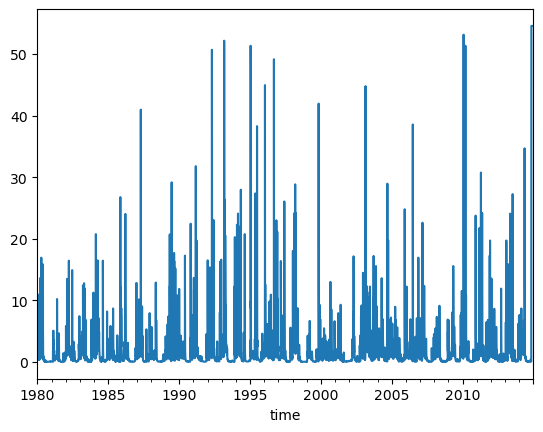

In [30]:
df_Q['Q'].plot()
# ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-06-01')))

In [31]:
# same on other ewatercycle stuff, guess you don't run the last step
# n_timesteps = len(ds.time.values) - 1
# or better 
# n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step)

In [32]:
list(dict(ensemble.ensemble_list[0].model.parameters).keys()) + list(dict(ensemble.ensemble_list[0].model.states).keys())

['Imax',
 'Ce',
 'Sumax',
 'Beta',
 'Pmax',
 'Tlag',
 'Kf',
 'Ks',
 'Si',
 'Su',
 'Sf',
 'Ss']

In [33]:
ensemble.ensemble_list[0].model.time

875664000.0

In [34]:
ensemble.ensemble_list[2].get_state_vector()

array([8.43465586e-01, 7.08039351e-01, 4.63110572e+01, 1.21562168e+00,
       1.13647613e-01, 9.00000000e+00, 1.31775457e-02, 6.98588981e-03,
       0.00000000e+00, 1.00000000e+02, 0.00000000e+00, 5.00000000e+00])

In [35]:
set_arr = np.ones(12)
ensemble.ensemble_list[2].set_state_vector(set_arr)

In [36]:
ensemble.ensemble_list[2].get_state_vector()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [37]:
ensemble.update()

In [38]:
ensemble.ensemble_list[2].get_state_vector()

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])

In [39]:
ensemble.update()

In [40]:
lst = []
for i in range(3):
    lst.append(ensemble.ensemble_list[i].get_state_vector())

In [41]:
lst

[array([5.26533749e+00, 2.84308854e-01, 2.72671108e+02, 3.35813125e+00,
        4.90187516e-02, 3.00000000e+00, 5.22550003e-02, 9.54935602e-03,
        0.00000000e+00, 9.54847371e+01, 0.00000000e+00, 4.93922458e+00]),
 array([8.89488863e-01, 9.50995818e-01, 1.63280550e+02, 1.31225589e+00,
        2.43323313e-01, 8.00000000e+00, 2.45669551e-02, 9.95159242e-03,
        0.00000000e+00, 9.74589873e+01, 0.00000000e+00, 5.18949072e+00]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.])]

In [42]:
# set up arrays
n_storage_terms = len(stor_names)
n_param_terms = len(param_names)
Q_m_arr = np.zeros(n_particles)
storage_terms_arr = np.zeros((n_particles, n_storage_terms))
parameter_terms_arr = np.zeros((n_particles, n_param_terms))
t_lag_max = 100 # for now? 
index_t_lag = 5 # fith parameter (base 0)
print(f'{index_t_lag}th index is {param_names[index_t_lag]}')
lag_vector_memory_arr = np.zeros((n_particles, t_lag_max))

5th index is Tlag


In [43]:
print(param_names)
print(stor_names)

['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks']
['Si', 'Su', 'Sf', 'Ss']


In [46]:
start = datetime.now()
time = []
Q_m_lst = []
storage_terms_lst = []
parameter_terms_lst = []
## running for whole timeseries takes long, just do first couple of months to see inpact
# while ref_model.time < ref_model.start_time + n_timesteps * ref_model.time_step:
while ref_model.time < ref_model.end_time:

    # before the update, the model is still at t_index = 0: thus also get the timestep then. 
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    # print(f'{t_index}/{n_timesteps}',end="\r")
    # run model forward

    ensemble.update()
    Q_m_arr = ensemble.get_value("Q")
    state_vector = np.array([ensemble.get_value(variable_name) for variable_name in [stor_names, param_names]]).T

    for m_index, ensembleMember in enumerate(ensemble.ensemble_list):        
        ## get the memory vector - leave this for now? 
        t_lag = int(parameter_terms_arr[m_index, t_index, index_t_lag])
        lag_vector_memory_arr[m_index, t_index, :t_lag] = np.array([ensembleMember.get_value(f"memory_vector{i}") for i in range(t_lag)]).flatten()
    
    #### Part of the PF section? 
    Q_obs = df_Q.loc[pd.Timestamp(ref_model.time_as_datetime.date()),"Q"] # get observed value from DF 
    
    # add error to Q_obs - roughly sig^2 = (0.1 * Q_obs)^2 - clark 2008
    likelihood = generate_weights(Q_m_arr, Q_obs) 
    resample_indices = random.choices(population=np.arange(n_particles),weights=likelihood, k=n_particles)
    
    new_state_vector    = state_vector.copy()[resample_indices]
    new_lag        = lag_vector_memory_arr[:,t_index].copy()[resample_indices] # dont have a way to set new lag function as of yet

    ## add noise
    ## TODO: literature to choose sigma - maybe make sigma dependant on the parameter: i.e. %age of parameter
    sigma = 0.00005
    # sigma_p = np.var(new_parameters,axis=0) + 1e-50#0.
    sigma_p = [sigma] * len(param_names)
    # CONSTRRAIN?
    new_parameters = np.array([np.array([min(max(perturbed + add_noise(sigma_p[param_index]),1e-6),p_max_initial[param_index]) for perturbed in par]) 
                               for param_index, par in enumerate(new_parameters.T)]).T
    
    # sigma_s = np.var(new_storage,axis=0) +  1e-50 # 0.05
    sigma_s = [sigma] * len(stor_names)
    new_storage    = np.array([np.array([max(perturbed + add_noise(sigma_s[stor_index]),1e-6) for perturbed in stor]) 
                               for stor_index, stor in enumerate(new_storage.T)]).T
    
    
    for p_index, parameter in enumerate(param_names):
        ensemble.set_value(parameter, new_parameters[:, p_index])
    
    for s_index, storage in enumerate(stor_names):
        ensemble.set_value(storage, new_storage[:, s_index])
    
    # update the parameters & states
    for index, ensembleMember in enumerate(ensemble.ensemble_list):
        # TODO: adjust so that tLag cant go to 0
        new_tlag = new_parameters[index, index_t_lag]
        [ensembleMember.set_value(f"memory_vector{mem_index}", np.array([new_lag[index, mem_index]])) for mem_index in range(int(new_tlag))]

    # advance the index
    t_index+=1 

## TODO: way to fix this?
# units = {}
# for name in stor_names + param_names:
#     units[name] = ref_model.get_units(name)

print('Finalising')
# end model - IMPORTANT! when working with dockers
ensemble.finalize()

end = datetime.now()
run = end - start
print(f'{run.seconds//60}min,{run.seconds%60}sec')

TypeError: unhashable type: 'list'

### process the numpy data into easily acessed data types

In [ ]:
save, load = True, False
current_time = str(datetime.now())[:-10].replace(":","_")

In [ ]:
if not load:
    df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

### process states and parameters into xarrys

In [ ]:
##### Save? 
if save:
    df_ensemble.to_feather(output_path /f'df_ensemble_{current_time}.feather')
if load:
    df_ensemble = pd.read_feather(glob.glob(str(output_path/'df_ensemble_*.feather'))[-1]) # read last

In [ ]:
# if load:
# TODO: obtain from model 
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q_m": "mm/d"}

In [ ]:
if not load:
    # combine the 3D numpy arr into one dataArray
    storage_terms_ds = xr.DataArray(storage_terms_arr,dims=["EnsembleMember","time","storage"],
                                    coords=[np.arange(n_particles),df_ensemble.index,stor_names],
                                    attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage term results from ewatercycle_HBV.model",
                                        "description":"Moddeled storage",
                                             "units": "mm"})
    
    parameter_terms_ds = xr.DataArray(parameter_terms_arr,dims=["EnsembleMember","time","parameter"],
                                coords=[np.arange(n_particles),df_ensemble.index,param_names],
                                    attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                           "history": f"Storage terms results from ewatercycle_HBV.model",})
    
    # even better is to combine into one Data_set_- this is most intuitive way for me - probably more ways
    data_vars = {}
    for i, name in enumerate(stor_names):
        storage_terms_i = xr.DataArray(storage_terms_arr[:,:,i],
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),df_ensemble.index],
                                      attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                            "description":"Moddeled storage",
                                                 "units": "mm"})
        data_vars[name] = storage_terms_i
    for i, name in enumerate(param_names):
        storage_terms_i = xr.DataArray(parameter_terms_arr[:,:,i],
                                       name=name,
                                       dims=["EnsembleMember","time"],
                                      coords=[np.arange(n_particles),df_ensemble.index],
                                      attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                               "history": f"Storage term results from ewatercycle_HBV.model",
                                            "description":"Moddeled storage",
                                                 "units": units[name]})
        data_vars[name] = storage_terms_i

    ds_combined = xr.Dataset(data_vars,
                             attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                    "history": f"Storage term results from ewatercycle_HBV.model",}
                              )

In [ ]:
##### Save? 
if save:
    storage_terms_ds.to_netcdf(output_path / f'storage_terms_ds_{current_time}.nc')
    parameter_terms_ds.to_netcdf(output_path / f'parameter_terms_ds_{current_time}.nc')
    ds_combined.to_netcdf(output_path / f'combined_ds_{current_time}.nc')
    
if load:
    storage_terms_ds = xr.open_dataarray(glob.glob(str(output_path / r'storage_terms_ds_*.nc'))[-1])
    parameter_terms_ds = xr.open_dataarray(glob.glob(str(output_path / 'parameter_terms_ds_*.nc'))[-1])
    ds_combined = xr.open_dataset(glob.glob(str(output_path / 'combined_ds_*.nc'))[-1])

# Plotting

In [ ]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax.legend(bbox_to_anchor=(1,1))
df_ensemble.plot(ax=ax,alpha=0.5,zorder=-1,legend=False)
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-12-01')))
ax.set_ylim((0,10))
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png")

Can calculate the mean of 50 particles as a reference

In [ ]:
mean_ensemble = df_ensemble.T.mean()
NSE_mean_ens = calc_NSE(df_Q.loc[time,"Q"],mean_ensemble.loc[time])

In [ ]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean {NSE_mean_ens:.2f}",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
# ax.set_xlim((pd.Timestamp('1997-08-01'),pd.Timestamp('1998-06-01')))
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_{current_time}.png",bbox_inches="tight",dpi=400);

In [ ]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1,figsize=(12,5))
# ax.plot(ds.time.values[:n_days],ds['Q'].values[:n_days],lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color="k")
# ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')

ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
ax_pr.bar(df_ensemble.index,ds['pr'].values[:n_timesteps],zorder=-15,label="Precipitation",color="grey")
ax_pr.legend(bbox_to_anchor=(1.25,0.8))

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensemble of {n_particles} particles");
if save:
    fig.savefig(figure_path / f"ensemble_run_for_{n_particles}_particles_bounds_P_{current_time}.png",bbox_inches="tight",dpi=400);

In [ ]:
n=5
fig, axs = plt.subplots(n,1,figsize=(12,n*2),sharex=True)

ax = axs[0]
df_Q.loc[Q_obs_t_lst,"Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations",color='k')
ax_pr = ax.twinx()
ax_pr.invert_yaxis()
ax_pr.set_ylabel(f"P [mm]")
ax_pr.bar(df_ensemble.index,ds['pr'].values[:n_timesteps],zorder=-10,label="Precipitation",color="grey")

ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"mean",zorder=-1)
ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.5,zorder=-10,label="bounds")
ax.legend(bbox_to_anchor=(1.25,1))
ax.set_ylabel("Q [mm]")

ax.set_title(f"Run ensemble of {n_particles} particles");

for i, S_name in enumerate(S_names):
    for j in range(n_particles):
        storage_terms_ds.isel(storage=i,EnsembleMember=j).plot(ax=axs[i+1],color=f"C{i}",alpha=0.5)
        axs[i+1].set_title(S_name)

# remove all unncecearry xlabels
[ax.set_xlabel(None) for ax in axs[:-1]]
[ax.set_ylabel("S [mm]") for ax in axs[1:]]
if save:
    fig.savefig(figure_path / f"ensemble_run_for__{n_particles}_particles_storages_{current_time}.png",bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(1,1)
for i in range(n_particles):
    storage_terms_ds.sel(storage="Ss").isel(EnsembleMember=i).plot(ax=ax)

In [ ]:
fig, ax = plt.subplots(1,1)

parameter="Tlag"
for i in range(n_particles):
    parameter_terms_ds.sel(parameter=parameter).isel(EnsembleMember=i).plot(ax=ax)
ax.set_title(f'parameter={parameter} for {n_particles} Ensemble Members')

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    for i in range(n_particles):
        parameter_terms_ds.sel(parameter=parameter).isel(EnsembleMember=i).plot(ax=ax,alpha=0.3)
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[parameter]}]')
if save:
    fig.savefig(figure_path /  f"ensemble_run_for__{n_particles}_particles_parameters_{current_time}.png",bbox_inches="tight",dpi=400)